In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils
import utils

from calitp.tables import tbl
from calitp import query_sql
import calitp.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
import rt_filter_map_plot

from IPython.display import display, Markdown, Latex, HTML
import json

In [2]:
## parameters cell
itp_id = 159

In [3]:
# Parameters
district = "04 - Oakland"
itp_id = 167


In [4]:
airtable_organizations = (
    tbl.airtable.california_transit_organizations()
    >> select(_.itp_id, _.name, _.caltrans_district,
              _.website, _.ntp_id, _.drmt_organization_name)
    >> filter(_.itp_id == itp_id)
    >> collect()
)

In [5]:
# airtable_organizations

In [6]:
analysis_date = dt.date(2022, 3, 30)
if itp_id == 273:
    analysis_date = dt.date(2022, 2, 8) # #override for SacRT 

In [7]:
month_day = analysis_date.strftime('%m_%d')

In [8]:
trips = pd.read_parquet(f'{utils.GCS_FILE_PATH}rt_trips/{itp_id}_{month_day}.parquet')

In [9]:
stop_delay = gpd.read_parquet(f'{utils.GCS_FILE_PATH}stop_delay_views/{itp_id}_{month_day}.parquet')
stop_delay['arrival_time'] = stop_delay.arrival_time.map(lambda x: dt.datetime.fromisoformat(x))
stop_delay['actual_time'] = stop_delay.actual_time.map(lambda x: dt.datetime.fromisoformat(x))

In [10]:
%%capture
routelines = utils.get_routelines(itp_id, analysis_date)

In [11]:
%%capture
rt_day = rt_filter_map_plot.RtFilterMapper(trips, stop_delay, routelines)

In [12]:
%%capture_parameters
agency_name = rt_day.calitp_agency_name
district = airtable_organizations.caltrans_district.iloc[0]
agency_name, district

# Tri-Valley Wheels

## About These Maps:

* Each map shows bus (and rail, if applicable) speeds for Tri-Valley Wheels, with a map each for the morning peak, midday, and afternoon peak periods.
* On the map, routes are split into segments corresponding to the distance between two stops, allowing you to focus on specific portions of the route experiencing a slowdown.
* Route segments are arrow-shaped to indicate direction of travel.
* Hover over, or click, a segment with your mouse to see the exact speed, route name, and transit service frequency in that segment. 
    * Higher-frequency routes (3+ trips per hour) are especially important, since those slowdowns correspond to more vehicles, and riders, delayed in traffic.

In [13]:
## avoid papermill errors when map fails to render
m = None

## Morning Peak

In [14]:
%%capture
rt_day.set_filter(start_time='06:00', end_time='09:00')

In [15]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [16]:
m

In [17]:
rt_day.describe_delayed_routes()

AM Peak most delayed routes: 
 * 504, Dublin Ranch, Westbound: 13.0 minutes late on average
 * 501, Positano Hill, Westbound: 11.0 minutes late on average
 * 2, East Dublin, Eastbound: 10.0 minutes late on average
 * 502, Emerald Glen, Westbound: 10.0 minutes late on average
 * 501, Positano Hill, Westbound: 9.0 minutes late on average

## Midday

In [18]:
%%capture
rt_day.set_filter(start_time='10:00', end_time='14:00')

In [19]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [20]:
m

In [21]:
rt_day.describe_delayed_routes()

Midday most delayed routes: 
 * 30R, Dublin - Livermore via College, Eastbound: 9.0 minutes late on average
 * 3, Stoneridge, Eastbound: 4.0 minutes late on average
 * 14, Pleasanton - Livermore via Outlets, Westbound: 3.0 minutes late on average
 * 10R, Pleasanton - Livermore via Stanley, Eastbound: 2.0 minutes late on average
 * 1, Santa Rita Jail, Northbound: 2.0 minutes late on average

## Afternoon Peak

In [22]:
%%capture
rt_day.set_filter(start_time='15:00', end_time='19:00')

In [23]:
%%capture
m = rt_day.segment_speed_map(how='low_speeds', no_title=True)

In [24]:
m

In [25]:
rt_day.describe_delayed_routes()

PM Peak most delayed routes: 
 * 501, Positano Hill, Eastbound: 12.0 minutes late on average
 * 502, Emerald Glen, Eastbound: 11.0 minutes late on average
 * 504, Dublin Ranch, Eastbound: 9.0 minutes late on average
 * 30R, Dublin - Livermore via College, Eastbound: 4.0 minutes late on average
 * 501, Positano Hill, Eastbound: 4.0 minutes late on average

In [26]:
try:
    metrics_df = (rt_day.rt_trips
         >> group_by(_.route_short_name, _.direction_id)
         >> summarize(speed_variance = _.mean_speed_mph.var(),
                     mean_speed_mph = _.mean_speed_mph.mean(),
                     min_hour = _.median_time.min().hour,
                     max_hour = _.median_time.max().hour,
                     n = _.route_short_name.size)
         >> filter(_.min_hour <= 7, _.max_hour >= 15,
                   _.mean_speed_mph < _.mean_speed_mph.quantile(.6),
                   _.speed_variance, _.n > _.n.quantile(.4))
         >> arrange(-_.speed_variance)
         >> head(20)
        )
except Exception as e:
    pass
    # print(e)
## check that route has all-day span...

In [27]:
def map_from_metrics(rt_day, metrics_df):
    def show_title_and_map():
        try:
            am_map = rt_day.segment_speed_map(how='low_speeds', no_title = True)
            display(Markdown(f'20th Percentile Vehicle Speeds Between Stops{rt_day.filter_formatted}'))
            display(am_map)
        except Exception as e:
            display(Markdown(f'Map not available for this time/route'))
            pass
        return
    try:
        route_name = metrics_df.iloc[1,0]
        direction_id = metrics_df.iloc[1,1]
        # print(route_name, direction_id)
    except Exception as e:
        # print(e)
        return
    rt_day.set_filter(start_time='06:00', end_time='09:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()
    
    rt_day.set_filter(start_time='10:00', end_time='14:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    rt_day.set_filter(start_time='15:00', end_time='19:00',
                      route_names=[route_name], direction_id = direction_id)
    show_title_and_map()

    return

## Daily Delay Patterns

* This chart shows the distribution of average trip delays throughout the day. It can help find times of day where transit routes experience the worst delays. Since delay is calculated by comparing actual vehicle positions to the schedule, it's possible for even slow transit trips to have little delay if the schedule accounts for those slow conditions. Please use the speed maps alongside this delay information to get a more complete picture of transit performance.

Average Endpoint Delay by Hour of Day, All Routes, 06:00–22:00, Mar 30 (Wed)

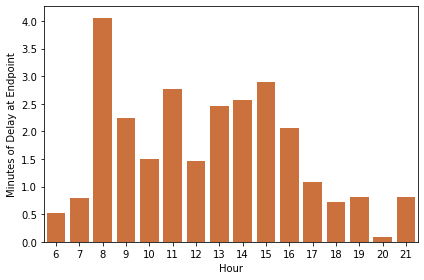

In [28]:
try:
    rt_day.set_filter(start_time='06:00', end_time='22:00')
    display(Markdown(f'Average Endpoint Delay by Hour of Day{rt_day.filter_formatted}'))

    rt_day.chart_delays(no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass

## Single-Route Detail Example

In [29]:
try:
    map_from_metrics(rt_day, metrics_df)
except Exception as e:
    # print(e)
    pass

## Single Route Speed Variability

* This chart shows the _variability_ in speeds experienced by afternoon peak trips on the route mapped above. In this chart, each vertical strip corresponds to a segment of the map above. Within each strip, each dot represents the speed experienced in that segment by each trip in the afternoon peak. The segments are labelled by their end stop, generally a cross-street. Segments with high variability (some fast trips and some slow trips) might be better-suited to a different set of projects than segments that experience consistently slow speeds.

In [30]:
try:
    rt_day.filter['shape_ids'] = [(rt_day._filter(rt_day.rt_trips) >> count(_.shape_id)).shape_id.iloc[0]]

    display(Markdown(f'Speed Variablity by Stop Segment{rt_day.filter_formatted}'))

    ## filter to a max number of segments to display, split out title
    rt_day.chart_variability(num_segments=30, no_title=True);
except:
    display(Markdown(f'Chart not available for this agency'))
    pass

Speed Variablity by Stop Segment, All Routes, 06:00–22:00, Mar 30 (Wed)

Chart not available for this agency